# SPX - Equal-weighted randomly selected stocks vs Index

In an effort to combat the unwieldy costs but still benefit from the effects of diversification we will now randomly select a number of stocks from the SPX.  

Again the rebalancing will be monthly but for much less than the roughly 500 members of the SPX.

At LS Tech we have previously found 20 to be a reasonably good number to provide diversification benefits whilst keeping costs down(conventional wisdom sometimes suggests 50+).


In [86]:
""" Imports and setup parameters """

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,15]

import zipline
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules

from datetime import datetime
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf

from random import randrange

path_to_data = 'K:/Share/Personal/Ryan/CFA/TradingBook/ProjectOne/'

#Parameters
start_val = 1000000
number_of_runs = 10
number_of_stocks = 20 #size of portfolio

In [38]:
""" Strategy info """

def initialize(context):
    context.index_members = pd.read_csv(path_to_data + 'index-member-data.csv', index_col=0, parse_dates=[0])

    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open())


def rebalance(context, data):

    # date
    today = zipline.api.get_datetime().normalize()

    # index makeup for date
    index_constituents = context.index_members.loc[context.index_members.index == today]
    todays_universe = [symbol(ticker) for ticker in index_constituents.loc[:]['BBGID']]

    # trade logic
    global number_of_stocks
    buys = np.random.choice(todays_universe, size= number_of_stocks, replace=False).tolist()

    # sells
    for security in context.portfolio.positions:
        if (security not in buys):
            order_target_percent(security, 0.0)

    position_size = 1.0 / number_of_stocks  # equal weighted

    # buys
    for security in buys:
        order_target_percent(security, position_size)
        
    

In [39]:
""" Run backtest for number of runs"""

start = datetime(1998, 1, 1, tzinfo=pytz.UTC)
end = datetime(2018, 12, 31, tzinfo=pytz.UTC)

df = pd.DataFrame()

# run backtests
for i in np.arange(1, number_of_runs + 1):
    print('Processing run' + str(i))

    result = zipline.run_algorithm(
        start=start, end=end,
        initialize=initialize,
        capital_base=start_val,
        data_frequency='daily',
        bundle='random_stock_data')

    df[i] = result['portfolio_value']

Processing run1
Processing run2
Processing run3
Processing run4
Processing run5
Processing run6
Processing run7
Processing run8
Processing run9
Processing run10


In [43]:
""" Load in SPX to compare"""

spx_index = pd.read_csv(path_to_data + 'benchmark_returns/SPX.csv', index_col=0, parse_dates=True)
spx_index.index = spx_index.index.tz_localize('UTC')
spx_index = spx_index.loc[(spx_index.index >= start)  & (spx_index.index <= end)]

spx_index['perf'] = (spx_index.PX_LAST / spx_index.PX_LAST.shift(1) )
spx_index['perf'][0] = start_val
spx_index['perf'] = spx_index.perf.cumprod()

df.index = df.index.normalize()

df['spx_index'] = spx_index.perf


['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r']


[<matplotlib.text.Text at 0x23480080>, <matplotlib.text.Text at 0x21f14320>]

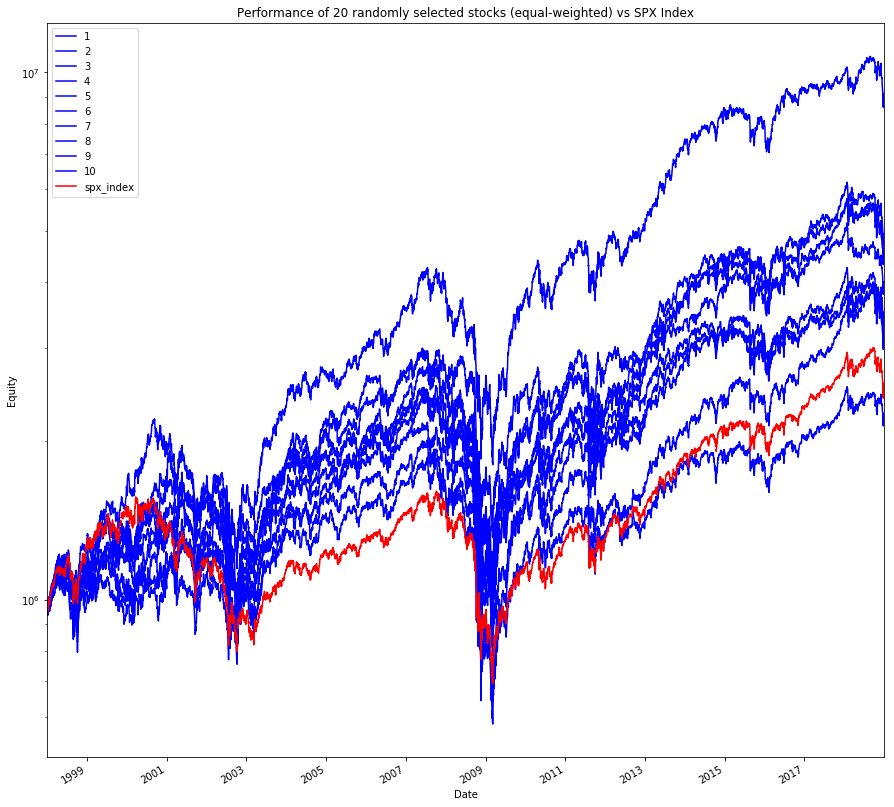

In [89]:
""" Setup style and plot"""

style = ['b' for _ in range(number_of_runs)] + ['r']
print(style)
title = 'Performance of ' +str(number_of_stocks) + ' randomly selected stocks (equal-weighted) vs SPX Index'
ax = df.plot(x=df.index, y=df.columns, kind="line", logy=True, style=style, title=title)
ax.set(xlabel="Date", ylabel="Equity")

# Conclusion

We can clearly see that on average these strategies outperform the standard SPX index as nine out of ten have a larger closing value.

Again this is not a recommended trading strategy as the drawdowns are still very chunky.  The one real outperfoming equity curve in this example seemed to get very lucky during the '08 crash.

Also this still does not take into account trading costs, which will be considerably more than that of the plain index.
